In [1]:
%%writefile train_utils.py

"""
Training utilities for EEG-ARNN
Includes data loading, training loops, evaluation metrics
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import mne
from pathlib import Path
from tqdm.auto import tqdm


class EEGDataset(Dataset):
    """PyTorch Dataset for EEG data"""
    def __init__(self, data, labels):
        """
        Parameters
        ----------
        data : np.ndarray
            EEG data of shape (n_trials, n_channels, n_timepoints)
        labels : np.ndarray
            Labels of shape (n_trials,)
        """
        self.data = torch.FloatTensor(data).unsqueeze(1)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def load_preprocessed_data(fif_path, tmin=-1.0, tmax=5.0, baseline=(-0.5, 0)):
    """
    Load preprocessed FIF file and extract epochs

    Parameters
    ----------
    fif_path : Path
        Path to preprocessed FIF file
    tmin : float
        Start time of epoch
    tmax : float
        End time of epoch
    baseline : tuple
        Baseline correction window

    Returns
    -------
    data : np.ndarray
        Epoched data (n_epochs, n_channels, n_timepoints)
    labels : np.ndarray
        Event labels (n_epochs,)
    """
    raw = mne.io.read_raw_fif(fif_path, preload=True, verbose='ERROR')

    # Try to find events from stim channels first
    try:
        events = mne.find_events(raw, verbose='ERROR')
        if len(events) == 0:
            return None, None
        event_ids = {f'T{i}': i for i in np.unique(events[:, 2])}
    except ValueError:
        # If no stim channels, try to get events from annotations
        events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')
        if len(events) == 0:
            return None, None

    epochs = mne.Epochs(
        raw, events,
        event_id=event_ids,
        tmin=tmin, tmax=tmax,
        baseline=baseline,
        preload=True,
        verbose='ERROR'
    )

    data = epochs.get_data()
    labels = epochs.events[:, 2]

    return data, labels


def filter_classes(data, labels, selected_classes):
    """
    Filter data to include only selected classes

    Parameters
    ----------
    data : np.ndarray
        EEG data
    labels : np.ndarray
        Labels
    selected_classes : list
        List of class IDs to keep

    Returns
    -------
    filtered_data : np.ndarray
    filtered_labels : np.ndarray
        Labels remapped to 0, 1, 2, ...
    """
    mask = np.isin(labels, selected_classes)
    filtered_data = data[mask]
    filtered_labels = labels[mask]

    label_mapping = {old: new for new, old in enumerate(selected_classes)}
    filtered_labels = np.array([label_mapping[label] for label in filtered_labels])

    return filtered_data, filtered_labels


def normalize_data(data):
    """
    Z-score normalization per channel

    Parameters
    ----------
    data : np.ndarray
        Shape (n_trials, n_channels, n_timepoints)

    Returns
    -------
    normalized_data : np.ndarray
        Z-score normalized data
    """
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return (data - mean) / std


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, all_preds, all_labels


def train_model(model, train_loader, val_loader, device, epochs=100, lr=0.001, patience=15):
    """
    Complete training loop with early stopping

    Parameters
    ----------
    model : nn.Module
        EEG-ARNN model
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    device : torch.device
        Device to train on
    epochs : int
        Maximum number of epochs
    lr : float
        Learning rate
    patience : int
        Early stopping patience

    Returns
    -------
    history : dict
        Training history
    best_model_state : dict
        State dict of best model
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    model.load_state_dict(best_model_state)

    return history, best_model_state


def cross_validate_subject(data, labels, num_channels, num_timepoints, num_classes,
                          device, n_splits=3, epochs=30, lr=0.001, batch_size=64, patience=8):
    """
    Perform k-fold cross-validation for a single subject

    Parameters
    ----------
    data : np.ndarray
        EEG data (n_trials, n_channels, n_timepoints)
    labels : np.ndarray
        Labels (n_trials,)
    num_channels : int
        Number of EEG channels
    num_timepoints : int
        Number of time points
    num_classes : int
        Number of classes
    device : torch.device
        Device to train on
    n_splits : int
        Number of CV folds
    epochs : int
        Max epochs per fold
    lr : float
        Learning rate

    Returns
    -------
    results : dict
        Cross-validation results
    """
    from models import EEGARNN

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    adjacency_matrices = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"  Fold {fold+1}/{n_splits}", end=" ", flush=True)

        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        X_train = normalize_data(X_train)
        X_val = normalize_data(X_val)

        train_dataset = EEGDataset(X_train, y_train)
        val_dataset = EEGDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        model = EEGARNN(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=40
        ).to(device)

        history, best_state = train_model(
            model, train_loader, val_loader, device,
            epochs=epochs, lr=lr, patience=patience
        )

        model.load_state_dict(best_state)
        _, val_acc, val_preds, val_labels = evaluate(
            model, val_loader, nn.CrossEntropyLoss(), device
        )

        adj_matrix = model.get_final_adjacency_matrix()
        adjacency_matrices.append(adj_matrix)

        print(f"-> Acc: {val_acc:.3f} (stopped at epoch {len(history['val_acc'])})")

        fold_results.append({
            'fold': fold,
            'val_acc': val_acc,
            'history': history,
            'preds': val_preds,
            'labels': val_labels
        })

    avg_adjacency = np.mean(adjacency_matrices, axis=0)

    return {
        'fold_results': fold_results,
        'avg_accuracy': np.mean([r['val_acc'] for r in fold_results]),
        'std_accuracy': np.std([r['val_acc'] for r in fold_results]),
        'adjacency_matrix': avg_adjacency
    }


def retrain_with_selected_channels(data, labels, selected_channel_indices, num_timepoints, num_classes,
                                   device, n_splits=3, epochs=25, lr=0.001, batch_size=64, patience=6):
    """
    Retrain model using only selected channels
    
    Parameters
    ----------
    data : np.ndarray
        Full EEG data (n_trials, n_channels, n_timepoints)
    labels : np.ndarray
        Labels (n_trials,)
    selected_channel_indices : np.ndarray
        Indices of channels to keep
    num_timepoints : int
        Number of time points
    num_classes : int
        Number of classes
    device : torch.device
        Device to train on
    n_splits : int
        Number of CV folds
    epochs : int
        Max epochs per fold
    lr : float
        Learning rate
        
    Returns
    -------
    results : dict
        Cross-validation results with selected channels
    """
    from models import EEGARNN
    
    # Select only the specified channels
    data_subset = data[:, selected_channel_indices, :]
    num_channels_subset = len(selected_channel_indices)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(data_subset, labels)):
        X_train, X_val = data_subset[train_idx], data_subset[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        X_train = normalize_data(X_train)
        X_val = normalize_data(X_val)
        
        train_dataset = EEGDataset(X_train, y_train)
        val_dataset = EEGDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        model = EEGARNN(
            num_channels=num_channels_subset,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=40
        ).to(device)
        
        history, best_state = train_model(
            model, train_loader, val_loader, device,
            epochs=epochs, lr=lr, patience=patience
        )
        
        model.load_state_dict(best_state)
        _, val_acc, val_preds, val_labels = evaluate(
            model, val_loader, nn.CrossEntropyLoss(), device
        )
        
        fold_results.append({
            'fold': fold,
            'val_acc': val_acc,
            'history': history
        })
    
    return {
        'fold_results': fold_results,
        'avg_accuracy': np.mean([r['val_acc'] for r in fold_results]),
        'std_accuracy': np.std([r['val_acc'] for r in fold_results])
    }

Writing train_utils.py


In [2]:
%%writefile models.py

"""
EEG-ARNN Model Architecture
Implements the 3-fold TFEM-CARM architecture from the paper.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class TFEM(nn.Module):
    """
    Temporal Feature Extraction Module
    Uses 1D temporal convolution to extract time-domain features
    """
    def __init__(self, in_channels, out_channels, kernel_size=16, pool_size=2, use_pool=True):
        super(TFEM, self).__init__()
        self.use_pool = use_pool

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(1, kernel_size),
            padding=(0, kernel_size // 2),
            bias=False
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ELU()

        if use_pool:
            self.pool = nn.AvgPool2d(kernel_size=(1, pool_size))

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        if self.use_pool:
            x = self.pool(x)

        return x


class CARM(nn.Module):
    """
    Channel Active Reasoning Module
    Learns channel connectivity via graph convolution

    Implements the proper GCN formula from the paper:
    H = D_tilde^(-1/2) * W_tilde * D_tilde^(-1/2) * X * Theta

    Where:
        W_tilde = W* + I (add self-loops)
        D_tilde = degree matrix
        X = input features
        Theta = learnable weights
    """
    def __init__(self, num_channels, hidden_dim=40):
        super(CARM, self).__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim

        # Learnable adjacency matrix W*
        self.W = nn.Parameter(torch.FloatTensor(num_channels, num_channels))
        nn.init.xavier_uniform_(self.W)

        # Learnable transformation theta (for graph convolution)
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)

        self.bn = nn.BatchNorm2d(hidden_dim)
        self.activation = nn.ELU()

    def forward(self, x):
        """
        Args:
            x: (batch_size, hidden_dim, num_channels, time_steps)

        Returns:
            out: (batch_size, hidden_dim, num_channels, time_steps)
            A_sym: Symmetric adjacency matrix
        """
        batch_size, hidden_dim, num_channels, time_steps = x.size()

        # 1. Get symmetric adjacency matrix
        A = torch.sigmoid(self.W)
        A_sym = (A + A.t()) / 2

        # 2. Add self-loops: W_tilde = W* + I
        I = torch.eye(num_channels, device=x.device)
        A_tilde = A_sym + I

        # 3. Compute degree matrix D_tilde
        D_tilde = torch.diag(A_tilde.sum(dim=1))

        # 4. Compute normalized adjacency: D^(-1/2) * A_tilde * D^(-1/2)
        D_inv_sqrt = torch.pow(D_tilde, -0.5)
        D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0
        A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt

        # 5. Apply graph convolution on channel dimension
        # Reshape: (batch, hidden_dim, num_channels, time) -> (batch, time, num_channels, hidden_dim)
        x_reshaped = x.permute(0, 3, 2, 1)  # (batch, time, channels, features)

        # Reshape to (batch * time, num_channels, hidden_dim)
        x_flat = x_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)

        # Graph aggregation: (num_channels, num_channels) @ (batch*time, num_channels, hidden_dim)
        x_graph = torch.matmul(A_norm, x_flat)  # (batch*time, num_channels, hidden_dim)

        # Apply learnable transformation Theta
        x_graph = self.theta(x_graph)  # (batch*time, num_channels, hidden_dim)

        # Reshape back: (batch*time, num_channels, hidden_dim) -> (batch, time, num_channels, hidden_dim)
        x_graph = x_graph.view(batch_size, time_steps, num_channels, hidden_dim)

        # Permute back: (batch, time, num_channels, hidden_dim) -> (batch, hidden_dim, num_channels, time)
        out = x_graph.permute(0, 3, 2, 1)

        # 6. Batch normalization and activation
        out = self.bn(out)
        out = self.activation(out)

        return out, A_sym

    def get_adjacency_matrix(self):
        """Get the learned adjacency matrix"""
        with torch.no_grad():
            A = torch.sigmoid(self.W)
            A_sym = (A + A.t()) / 2
        return A_sym.cpu().numpy()


class EEGARNN(nn.Module):
    """
    Complete EEG-ARNN Architecture
    3-fold TFEM-CARM with final classification layer
    """
    def __init__(self, num_channels=64, num_timepoints=512, num_classes=4, hidden_dim=40):
        super(EEGARNN, self).__init__()

        self.num_channels = num_channels
        self.num_timepoints = num_timepoints
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        self.tfem1 = TFEM(in_channels=1, out_channels=hidden_dim, kernel_size=16, use_pool=False)
        self.carm1 = CARM(num_channels=num_channels, hidden_dim=hidden_dim)

        self.tfem2 = TFEM(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=16, pool_size=2, use_pool=True)
        self.carm2 = CARM(num_channels=num_channels, hidden_dim=hidden_dim)

        self.tfem3 = TFEM(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=16, pool_size=2, use_pool=True)
        self.carm3 = CARM(num_channels=num_channels, hidden_dim=hidden_dim)

        test_input = torch.zeros(1, 1, num_channels, num_timepoints)
        with torch.no_grad():
            out = self._forward_features(test_input)
            flattened_size = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

        self.adjacency_matrices = {}

    def _forward_features(self, x):
        x = self.tfem1(x)
        x, A1 = self.carm1(x)

        x = self.tfem2(x)
        x, A2 = self.carm2(x)

        x = self.tfem3(x)
        x, A3 = self.carm3(x)

        self.adjacency_matrices = {'A1': A1, 'A2': A2, 'A3': A3}

        return x

    def forward(self, x):
        x = self._forward_features(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def get_final_adjacency_matrix(self):
        """Get the final learned adjacency matrix from CARM3"""
        return self.carm3.get_adjacency_matrix()

    def get_all_adjacency_matrices(self):
        """Get all adjacency matrices from all CARM layers"""
        return {
            'A1': self.carm1.get_adjacency_matrix(),
            'A2': self.carm2.get_adjacency_matrix(),
            'A3': self.carm3.get_adjacency_matrix()
        }


class ChannelSelector:
    """
    Channel selection using learned adjacency matrix
    Implements both Edge Selection (ES) and Aggregation Selection (AS)
    """
    def __init__(self, adjacency_matrix, channel_names):
        """
        Parameters
        ----------
        adjacency_matrix : np.ndarray
            Learned adjacency matrix (num_channels, num_channels)
        channel_names : list
            List of channel names
        """
        self.adj_matrix = adjacency_matrix
        self.channel_names = np.array(channel_names)
        self.num_channels = len(channel_names)

    def edge_selection(self, k):
        """
        Edge Selection (ES) method
        Selects channels based on strongest pairwise connections

        Parameters
        ----------
        k : int
            Number of edges to select

        Returns
        -------
        selected_channels : list
            List of selected channel names
        selected_indices : np.ndarray
            Indices of selected channels
        """
        edges = []
        for i in range(self.num_channels):
            for j in range(i+1, self.num_channels):
                edge_importance = abs(self.adj_matrix[i, j]) + abs(self.adj_matrix[j, i])
                edges.append((i, j, edge_importance))

        sorted_edges = sorted(edges, key=lambda x: x[2], reverse=True)

        top_k_edges = sorted_edges[:k]

        selected_indices = set()
        for i, j, _ in top_k_edges:
            selected_indices.add(i)
            selected_indices.add(j)

        selected_indices = np.array(sorted(selected_indices))
        selected_channels = self.channel_names[selected_indices].tolist()

        return selected_channels, selected_indices

    def aggregation_selection(self, k):
        """
        Aggregation Selection (AS) method
        Selects channels based on aggregate connection strength

        Parameters
        ----------
        k : int
            Number of channels to select

        Returns
        -------
        selected_channels : list
            List of selected channel names
        selected_indices : np.ndarray
            Indices of selected channels
        """
        channel_scores = np.sum(np.abs(self.adj_matrix), axis=1)

        selected_indices = np.argsort(channel_scores)[-k:]
        selected_indices = np.sort(selected_indices)

        selected_channels = self.channel_names[selected_indices].tolist()

        return selected_channels, selected_indices

    def visualize_adjacency(self, save_path=None):
        """Visualize the adjacency matrix"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(
            self.adj_matrix,
            xticklabels=self.channel_names,
            yticklabels=self.channel_names,
            cmap='RdYlGn',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Connection Strength'},
            ax=ax
        )
        ax.set_title('Learned Channel Adjacency Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        return fig

Writing models.py


In [3]:
import sys
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import mne

# IMPORTANT: Force reload train_utils to get latest fixes
import importlib
import train_utils
importlib.reload(train_utils)

from models import EEGARNN, ChannelSelector
from train_utils import (
    load_preprocessed_data, filter_classes, normalize_data,
    cross_validate_subject, EEGDataset
)

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Verify the fix is loaded
print("\n" + "="*80)
print("VERIFICATION: Checking if train_utils.py fix is loaded...")
print("="*80)
import inspect
source = inspect.getsource(load_preprocessed_data)
if 'events_from_annotations' in source:
    print("✓ GOOD: train_utils.py has the annotations fix!")
else:
    print("✗ ERROR: train_utils.py is still using old code!")
    print("  → Please restart Jupyter kernel: Kernel → Restart Kernel")
    print("  → Then re-run all cells from the top")
print("="*80)

Using device: cuda
GPU: Tesla P100-PCIE-16GB

VERIFICATION: Checking if train_utils.py fix is loaded...
✓ GOOD: train_utils.py has the annotations fix!


In [4]:

EXPERIMENT_CONFIG = {
    'data': {
        'preprocessed_dir': Path('/kaggle/input/eeg-preprocessed-data/derived/preprocessed'),
        'index_file': Path('/kaggle/input/eeg-preprocessed-data/derived/physionet_preprocessed_index.csv'),
        'selected_classes': [1, 2],  # T1, T2 (or [1, 2, 3, 4] for 4-class)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 20,  # Increased from 10 to 20
        'learning_rate': 0.001,
        'batch_size': 32,
        'n_folds': 2,
        'patience': 8
    },
    'gating': {
        'enabled': True,
        'l1_lambda': 1e-3,
        'gate_init': 0.9
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25, 'all'],  # Different k to test
        'methods': ['ES', 'AS']  # Edge Selection, Aggregation Selection
    },
    'output': {
        'results_dir': Path('results'),
        'models_dir': Path('saved_models'),
        'gated_results_file': 'trial4_gated_subject_results.csv',
        'gate_importance_file': 'trial4_gate_importances.csv',
        'channel_selection_results_file': 'trial4_channel_selection_results.csv',
        'retrain_results_file': 'trial4_retrain_results.csv',
        'baseline_results_file': 'subject_results.csv',
        'comparison_file': 'trial4_gated_vs_baseline.csv',
        'results_summary_figure': 'trial4_gated_results_summary.png',
        'adjacency_prefix': 'trial4_adjacency'
    },
    'max_subjects': 10  # Train on only 10 subjects
}

EXPERIMENT_CONFIG['output']['results_dir'].mkdir(exist_ok=True)
EXPERIMENT_CONFIG['output']['models_dir'].mkdir(exist_ok=True)

print('Experiment Configuration:')
print(json.dumps(EXPERIMENT_CONFIG, indent=2, default=str))


Experiment Configuration:
{
  "data": {
    "preprocessed_dir": "/kaggle/input/eeg-preprocessed-data/derived/preprocessed",
    "index_file": "/kaggle/input/eeg-preprocessed-data/derived/physionet_preprocessed_index.csv",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "model": {
    "hidden_dim": 40,
    "epochs": 20,
    "learning_rate": 0.001,
    "batch_size": 32,
    "n_folds": 2,
    "patience": 8
  },
  "gating": {
    "enabled": true,
    "l1_lambda": 0.001,
    "gate_init": 0.9
  },
  "channel_selection": {
    "k_values": [
      10,
      15,
      20,
      25,
      "all"
    ],
    "methods": [
      "ES",
      "AS"
    ]
  },
  "output": {
    "results_dir": "results",
    "models_dir": "saved_models",
    "gated_results_file": "trial4_gated_subject_results.csv",
    "gate_importance_file": "trial4_gate_importances.csv",
    "channel_selection_results_file": "trial4_channel_selection

In [5]:

# Utilities for models with learnable channel gates
from copy import deepcopy
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def _init_gate_logits(num_channels: int, gate_init: float) -> torch.Tensor:
    init = torch.full((num_channels,), float(gate_init), dtype=torch.float32)
    init = torch.clamp(init, 1e-4, 1 - 1e-4)
    return torch.logit(init)


class GatedEEGARNN(EEGARNN):
    '''EEG-ARNN variant with learnable channel gates.'''
    def __init__(self, num_channels=64, num_timepoints=512, num_classes=4, hidden_dim=40, gate_init=0.9):
        super().__init__(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=hidden_dim
        )
        gate_logits = _init_gate_logits(num_channels, gate_init)
        self.gate_logits = nn.Parameter(gate_logits)
        self.latest_gates = None

    def get_gate_values(self):
        return torch.sigmoid(self.gate_logits)

    def forward(self, x):
        gate_values = torch.sigmoid(self.gate_logits)
        self.latest_gates = gate_values.detach().cpu()
        x = x * gate_values.view(1, 1, -1, 1)
        return super().forward(x)


def train_epoch_with_gates(model, dataloader, criterion, optimizer, device, l1_lambda=0.0):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    gate_penalties, gate_means = [], []

    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)

        if l1_lambda > 0 and hasattr(model, 'get_gate_values'):
            gate_values = model.get_gate_values()
            gate_penalty = l1_lambda * gate_values.abs().mean()
            loss = loss + gate_penalty
            gate_penalties.append(gate_penalty.item())
            gate_means.append(gate_values.mean().item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / max(len(dataloader), 1)
    accuracy = accuracy_score(all_labels, all_preds)
    avg_penalty = float(np.mean(gate_penalties)) if gate_penalties else 0.0
    avg_gate_mean = float(np.mean(gate_means)) if gate_means else 0.0

    return avg_loss, accuracy, avg_penalty, avg_gate_mean


def train_model_with_gates(model, train_loader, val_loader, device, epochs=100, lr=0.001,
                           patience=10, l1_lambda=0.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'gate_penalty': [],
        'gate_mean': []
    }

    best_val_acc = 0.0
    best_model_state = deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc, gate_penalty, gate_mean = train_epoch_with_gates(
            model, train_loader, criterion, optimizer, device, l1_lambda=l1_lambda
        )
        val_loss, val_acc, _, _ = train_utils.evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['gate_penalty'].append(gate_penalty)
        history['gate_mean'].append(gate_mean)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"    Early stopping at epoch {epoch + 1}")
            break

    return history, best_model_state


def cross_validate_subject_with_gates(
    data, labels, num_channels, num_timepoints, num_classes,
    device, n_splits=3, epochs=30, lr=0.001, batch_size=64, patience=8,
    l1_lambda=0.0, gate_init=0.9
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    adjacency_matrices = []
    gate_values_per_fold = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"  Fold {fold + 1}/{n_splits}", end=" ", flush=True)

        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        X_train = train_utils.normalize_data(X_train)
        X_val = train_utils.normalize_data(X_val)

        train_dataset = train_utils.EEGDataset(X_train, y_train)
        val_dataset = train_utils.EEGDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        model = GatedEEGARNN(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=EXPERIMENT_CONFIG['model']['hidden_dim'],
            gate_init=gate_init
        ).to(device)

        history, best_state = train_model_with_gates(
            model, train_loader, val_loader, device,
            epochs=epochs, lr=lr, patience=patience, l1_lambda=l1_lambda
        )

        model.load_state_dict(best_state)
        _, val_acc, val_preds, val_labels = train_utils.evaluate(
            model, val_loader, nn.CrossEntropyLoss(), device
        )

        adj_matrix = model.get_final_adjacency_matrix()
        adjacency_matrices.append(adj_matrix)

        gate_values = model.get_gate_values().detach().cpu().numpy()
        gate_values_per_fold.append(gate_values)

        fold_results.append({
            'fold': fold,
            'val_acc': val_acc,
            'history': history,
            'gate_mean': float(gate_values.mean()),
            'gate_std': float(gate_values.std()),
            'preds': val_preds,
            'labels': val_labels
        })

        print(f"-> Acc: {val_acc:.3f}")

    avg_adjacency = np.mean(adjacency_matrices, axis=0)
    avg_gate_values = np.mean(np.stack(gate_values_per_fold, axis=0), axis=0)

    return {
        'fold_results': fold_results,
        'avg_accuracy': np.mean([r['val_acc'] for r in fold_results]),
        'std_accuracy': np.std([r['val_acc'] for r in fold_results]),
        'adjacency_matrix': avg_adjacency,
        'gate_values_per_fold': gate_values_per_fold,
        'avg_gate_values': avg_gate_values
    }


In [6]:
index_df = pd.read_csv(EXPERIMENT_CONFIG['data']['index_file'])
success_df = index_df[index_df['status'] == 'success'].copy()

print(f"Total preprocessed runs: {len(index_df)}")
print(f"Successful runs: {len(success_df)}")
print(f"\nSubjects available: {success_df['subject'].nunique()}")
print(f"\nRuns per category:")
print(success_df.groupby('category')['run'].count())

success_df.head()

Total preprocessed runs: 669
Successful runs: 669

Subjects available: 51

Runs per category:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64


,subject,run,status,path,timestamp,original_sfreq,n_channels_original,duration_s,bad_channels,n_bad_channels,notch_applied,final_sfreq,n_channels_final,file_size_mb,category,task,bad_channels_interpolated
0,S001,R01,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-24T21:42:04.628656,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes open,NaN
1,S001,R02,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-24T21:42:06.393074,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes closed,NaN
2,S001,R04,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-24T21:42:06.882584,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close right fist (executed),NaN
3,S001,R05,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-24T21:42:07.598350,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both fists (executed),NaN
4,S001,R06,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-24T21:42:08.274567,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both feet (executed),NaN


In [7]:
# Filter motor-related runs (execution and imagery)
motor_runs = success_df[success_df['category'].isin(['motor_execution', 'motor_imagery'])].copy()

# Count runs per subject
subject_counts = motor_runs.groupby('subject').size().reset_index(name='num_runs')
subject_counts = subject_counts[subject_counts['num_runs'] >= 10]  # At least 10 runs

selected_subjects = subject_counts['subject'].tolist()

print(f"Subjects with >=10 motor runs: {len(selected_subjects)}")
print(f"\nFirst 10 subjects: {selected_subjects[:10]}")

# Limit to max_subjects for this experiment
max_subjects = EXPERIMENT_CONFIG.get('max_subjects', len(selected_subjects))
selected_subjects = selected_subjects[:max_subjects]

print(f"\nWill train on {len(selected_subjects)} subjects")
print(f"Selected subjects: {selected_subjects}")

Subjects with >=10 motor runs: 49

First 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']

Will train on 10 subjects
Selected subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']


In [8]:
def load_subject_data(subject_id, preprocessed_dir, motor_runs_df, config):
    """
    Load all motor runs for a subject and concatenate
    """
    import mne
    import numpy as np

    subject_runs = motor_runs_df[motor_runs_df['subject'] == subject_id]
    subject_path = Path(preprocessed_dir) / subject_id

    all_data, all_labels = [], []
    channel_names = None

    for _, run_info in subject_runs.iterrows():
        fif_path = Path(run_info.get('path', ''))

        # If path in CSV is invalid, rebuild it manually
        if not fif_path.exists():
            run_id = str(run_info.get('run', '')).zfill(2)
            fif_path = subject_path / f"{subject_id}{run_id}_preproc_raw.fif"


        if not fif_path.exists():
            print(f"Missing file for {subject_id}: {fif_path}")
            continue

        try:
            data, labels = load_preprocessed_data(
                fif_path,
                tmin=config['data']['tmin'],
                tmax=config['data']['tmax'],
                baseline=config['data']['baseline']
            )

            if data is not None and len(data) > 0:
                all_data.append(data)
                all_labels.append(labels)

                if channel_names is None:
                    raw = mne.io.read_raw_fif(fif_path, preload=False, verbose='ERROR')
                    channel_names = raw.ch_names

        except Exception as e:
            print(f"Error loading {fif_path.name}: {e}")
            continue

    if len(all_data) == 0:
        print(f"No valid runs for {subject_id}")
        return None, None, None

    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Filter to selected classes (e.g., [1, 2])
    all_data, all_labels = filter_classes(
        all_data, all_labels, config['data']['selected_classes']
    )

    return all_data, all_labels, channel_names


In [9]:

all_results = []
gate_analysis_records = []

for subject_id in tqdm(selected_subjects, desc="Training subjects (gated)"):
    print(f"{'='*80}")
    print(f"Training subject: {subject_id}")
    print(f"{'='*80}")

    data, labels, channel_names = load_subject_data(
        subject_id,
        EXPERIMENT_CONFIG['data']['preprocessed_dir'],
        motor_runs,
        EXPERIMENT_CONFIG
    )

    if data is None or len(data) < 30:
        print(f"Skipping {subject_id}: insufficient data")
        continue

    print(f"Data shape: {data.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
    print(f"Channels: {len(channel_names)}")

    num_channels = data.shape[1]
    num_timepoints = data.shape[2]
    num_classes = len(np.unique(labels))

    model_cfg = EXPERIMENT_CONFIG['model']
    gating_cfg = EXPERIMENT_CONFIG.get('gating', {})

    cv_results = cross_validate_subject_with_gates(
        data, labels,
        num_channels=num_channels,
        num_timepoints=num_timepoints,
        num_classes=num_classes,
        device=device,
        n_splits=model_cfg['n_folds'],
        epochs=model_cfg['epochs'],
        lr=model_cfg['learning_rate'],
        batch_size=model_cfg['batch_size'],
        patience=model_cfg.get('patience', 8),
        l1_lambda=gating_cfg.get('l1_lambda', 0.0),
        gate_init=gating_cfg.get('gate_init', 0.9)
    )

    gate_values = cv_results['avg_gate_values']
    gate_stats = {
        'mean': float(gate_values.mean()),
        'std': float(gate_values.std()),
        'min': float(gate_values.min()),
        'max': float(gate_values.max())
    }

    print(f"Gated accuracy: {cv_results['avg_accuracy']:.4f} +/- {cv_results['std_accuracy']:.4f}")
    print(f"Gate mean: {gate_stats['mean']:.4f} | min: {gate_stats['min']:.4f} | max: {gate_stats['max']:.4f}")

    result = {
        'subject': subject_id,
        'num_trials': int(len(data)),
        'num_channels': int(num_channels),
        'num_timepoints': int(num_timepoints),
        'num_classes': int(num_classes),
        'gated_acc': float(cv_results['avg_accuracy']),
        'gated_std': float(cv_results['std_accuracy']),
        'adjacency_matrix': cv_results['adjacency_matrix'],
        'channel_names': channel_names,
        'gate_values': gate_values.tolist(),
        'gate_values_per_fold': [gv.tolist() for gv in cv_results['gate_values_per_fold']],
        'gate_mean': gate_stats['mean'],
        'gate_std': gate_stats['std'],
        'gate_min': gate_stats['min'],
        'gate_max': gate_stats['max'],
        'fold_results': cv_results['fold_results']
    }

    all_results.append(result)

    for channel_name, gate_value in zip(channel_names, gate_values):
        gate_analysis_records.append({
            'subject': subject_id,
            'channel': channel_name,
            'gate_value': float(gate_value)
        })

print(f"{'='*80}")
print(f"Training complete for {len(all_results)} subjects")
print(f"{'='*80}")


Training subjects (gated):   0%|          | 0/10 [00:00<?, ?it/s]

Training subject: S001
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77]))
Channels: 64
  Fold 1/2     Early stopping at epoch 10
-> Acc: 0.784
  Fold 2/2     Early stopping at epoch 17
-> Acc: 0.817
Gated accuracy: 0.8009 +/- 0.0165
Gate mean: 0.9000 | min: 0.8992 | max: 0.9007
Training subject: S002
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77]))
Channels: 64
  Fold 1/2 -> Acc: 0.767
  Fold 2/2 -> Acc: 0.774
Gated accuracy: 0.7706 +/- 0.0033
Gate mean: 0.8999 | min: 0.8986 | max: 0.9012
Training subject: S005
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84]))
Channels: 64
  Fold 1/2     Early stopping at epoch 13
-> Acc: 0.857
  Fold 2/2     Early stopping at epoch 19
-> Acc: 0.841
Gated accuracy: 0.8492 +/- 0.0079
Gate mean: 0.9000 | min: 0.8988 | max: 0.9010
Training subject: S006
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84]))
Channels: 64
  Fold 1/2 -> Acc: 0.810
  Fold 2/2     Early stopping at epoc

In [10]:

gate_importance_df = pd.DataFrame(gate_analysis_records)

if len(gate_importance_df) > 0:
    subject_gate_summary = gate_importance_df.groupby('subject')['gate_value'].agg(['mean', 'std', 'min', 'max']).reset_index()
    print('Per-subject gate statistics:')
    display(subject_gate_summary)

    channel_gate_summary = (
        gate_importance_df.groupby('channel')['gate_value']
        .agg(['mean', 'std'])
        .sort_values('mean', ascending=False)
    )
    print('Top channels by mean gate value:')
    display(channel_gate_summary.head(15))

    gate_importance_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['gate_importance_file']
    channel_gate_summary.reset_index().to_csv(gate_importance_path, index=False)
    print(f"{'='*80}")
    print(f"Gate importance saved to: {gate_importance_path}")

    channel_gate_summary_df = channel_gate_summary.reset_index()
else:
    print('No gate values recorded. Ensure training ran successfully.')
    channel_gate_summary_df = pd.DataFrame()


Per-subject gate statistics:


,subject,mean,std,min,max
0,S001,0.899959,0.000418,0.899224,0.900711
1,S002,0.899920,0.000588,0.898622,0.901162
2,S005,0.899991,0.000547,0.898837,0.901006
3,S006,0.899946,0.000458,0.898999,0.900788
4,S007,0.899931,0.000456,0.899056,0.900945
5,S008,0.899941,0.000431,0.898842,0.900780
6,S011,0.899942,0.000515,0.899065,0.901057
7,S014,0.899960,0.000590,0.898860,0.900987
8,S015,0.899912,0.000430,0.899137,0.900747
9,S016,0.899909,0.000587,0.898336,0.901391


Top channels by mean gate value:


,mean,std
channel,,
Cp3,0.900360,0.000534
P3,0.900285,0.000338
Af3,0.900217,0.000444
C4,0.900214,0.000480
Cp2,0.900211,0.000370
C2,0.900186,0.000474
Af7,0.900181,0.000496
Po3,0.900168,0.000529
Fpz,0.900163,0.000378


Gate importance saved to: results/trial4_gate_importances.csv


In [11]:
channel_selection_results = []

if len(all_results) > 0:
    for result in tqdm(all_results, desc="Channel selection experiments"):
        subject_id = result['subject']
        adj_matrix = result['adjacency_matrix']
        channel_names = result['channel_names']
        
        print(f"\nProcessing channel selection for {subject_id}")
        
        selector = ChannelSelector(adj_matrix, channel_names)
        
        for method in EXPERIMENT_CONFIG['channel_selection']['methods']:
            print(f"  Method: {method}")
            
            for k in EXPERIMENT_CONFIG['channel_selection']['k_values']:
                if k == 'all':
                    k_val = result['num_channels']
                    selected_channels = channel_names
                else:
                    k_val = min(k, result['num_channels'])  # Don't exceed available channels
                    
                    if method == 'ES':
                        selected_channels, _ = selector.edge_selection(k_val)
                    else:  # AS
                        selected_channels, _ = selector.aggregation_selection(k_val)
                
                print(f"    k={k_val}: {len(selected_channels)} channels selected")
                
                channel_selection_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy_full': result['gated_acc']
                })

    channel_selection_df = pd.DataFrame(channel_selection_results)
    print(f"\nChannel selection results: {len(channel_selection_df)} experiments")
    display(channel_selection_df.head(10))
else:
    channel_selection_df = pd.DataFrame()
    print("\nNo results available for channel selection experiments.")

Channel selection experiments:   0%|          | 0/10 [00:00<?, ?it/s]


Processing channel selection for S001
  Method: ES
    k=10: 18 channels selected
    k=15: 24 channels selected
    k=20: 30 channels selected
    k=25: 36 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S002
  Method: ES
    k=10: 20 channels selected
    k=15: 28 channels selected
    k=20: 32 channels selected
    k=25: 36 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S005
  Method: ES
    k=10: 17 channels selected
    k=15: 23 channels selected
    k=20: 29 channels selected
    k=25: 35 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected

,subject,method,k,num_selected,selected_channels,accuracy_full
0,S001,ES,10,18,"[Fc4, C1, C2, Cp4, Fp1, Fpz, Afz, Af8, F3, F1,...",0.800937
1,S001,ES,15,24,"[Fc4, Fc6, C1, C2, Cp5, Cp4, Cp6, Fp1, Fpz, Af...",0.800937
2,S001,ES,20,30,"[Fc5, Fc3, Fc4, Fc6, C1, C2, Cp5, Cp4, Cp6, Fp...",0.800937
3,S001,ES,25,36,"[Fc5, Fc3, Fcz, Fc4, Fc6, C1, C2, C4, Cp5, Cp4...",0.800937
4,S001,ES,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...",0.800937
5,S001,AS,10,10,"[Fc4, C1, C2, C6, Af3, T10, P1, Po7, Po3, O1]",0.800937
6,S001,AS,15,15,"[Fc4, C1, C2, C6, Cp1, Af3, Afz, Af8, F6, T10,...",0.800937
7,S001,AS,20,20,"[Fc4, C1, C2, C6, Cp1, Af3, Afz, Af8, F3, F6, ...",0.800937
8,S001,AS,25,25,"[Fc4, C1, C2, C6, Cp1, Af3, Afz, Af8, F5, F3, ...",0.800937
9,S001,AS,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...",0.800937


In [12]:

from train_utils import retrain_with_selected_channels

# Store all retraining results
retrain_results = []

if len(all_results) > 0:
    subject_data_cache = {}

    for result in all_results:
        subject_id = result['subject']
        print(f"Loading data for {subject_id}")

        data, labels, channel_names = load_subject_data(
            subject_id,
            EXPERIMENT_CONFIG['data']['preprocessed_dir'],
            motor_runs,
            EXPERIMENT_CONFIG
        )

        if data is None:
            continue

        subject_data_cache[subject_id] = {
            'data': data,
            'labels': labels,
            'channel_names': channel_names
        }

    print(f"{'='*80}")
    print('RETRAINING WITH SELECTED CHANNELS')
    print(f"{'='*80}")

    for result in tqdm(all_results, desc='Retraining subjects'):
        subject_id = result['subject']

        if subject_id not in subject_data_cache:
            continue

        cache = subject_data_cache[subject_id]
        data = cache['data']
        labels = cache['labels']
        channel_names = cache['channel_names']

        print(f"Retraining {subject_id}")

        selector = ChannelSelector(result['adjacency_matrix'], channel_names)

        for method in EXPERIMENT_CONFIG['channel_selection']['methods']:
            for k in EXPERIMENT_CONFIG['channel_selection']['k_values']:
                if k == 'all':
                    continue

                k_val = min(k, result['num_channels'])

                if method == 'ES':
                    selected_channels, selected_indices = selector.edge_selection(k_val)
                else:
                    selected_channels, selected_indices = selector.aggregation_selection(k_val)

                print(f"  {method} k={k_val}: Retraining with {len(selected_channels)} channels...")

                retrain_res = retrain_with_selected_channels(
                    data, labels,
                    selected_channel_indices=selected_indices,
                    num_timepoints=result['num_timepoints'],
                    num_classes=result['num_classes'],
                    device=device,
                    n_splits=EXPERIMENT_CONFIG['model']['n_folds'],
                    epochs=EXPERIMENT_CONFIG['model']['epochs'],
                    lr=EXPERIMENT_CONFIG['model']['learning_rate']
                )

                acc_drop = result['gated_acc'] - retrain_res['avg_accuracy']

                print(f"    Accuracy: {retrain_res['avg_accuracy']:.4f} +/- {retrain_res['std_accuracy']:.4f}")
                print(f"    Drop from full: {acc_drop:.4f} ({acc_drop/result['gated_acc']*100:.1f}%)")

                retrain_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_channels_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy': retrain_res['avg_accuracy'],
                    'std': retrain_res['std_accuracy'],
                    'full_channels_acc': result['gated_acc'],
                    'accuracy_drop': acc_drop,
                    'accuracy_drop_pct': acc_drop / result['gated_acc'] * 100
                })

    retrain_df = pd.DataFrame(retrain_results)
    print(f"{'='*80}")
    print(f'Retraining complete: {len(retrain_df)} experiments')
    print(f"{'='*80}")

    retrain_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['retrain_results_file']
    retrain_df.to_csv(retrain_path, index=False)
    print(f"Retrain results saved to: {retrain_path}")
else:
    retrain_df = pd.DataFrame()
    print('No results to retrain. Please run training first.')


Loading data for S001
Loading data for S002
Loading data for S005
Loading data for S006
Loading data for S007
Loading data for S008
Loading data for S011
Loading data for S014
Loading data for S015
Loading data for S016
RETRAINING WITH SELECTED CHANNELS


Retraining subjects:   0%|          | 0/10 [00:00<?, ?it/s]

Retraining S001
  ES k=10: Retraining with 18 channels...
    Accuracy: 0.7275 +/- 0.0638
    Drop from full: 0.0734 (9.2%)
  ES k=15: Retraining with 24 channels...
    Accuracy: 0.6711 +/- 0.0332
    Drop from full: 0.1298 (16.2%)
  ES k=20: Retraining with 30 channels...
    Accuracy: 0.7797 +/- 0.1073
    Drop from full: 0.0213 (2.7%)
  ES k=25: Retraining with 36 channels...
    Accuracy: 0.7318 +/- 0.0421
    Drop from full: 0.0692 (8.6%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.8139 +/- 0.0122
    Drop from full: -0.0130 (-1.6%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.5964 +/- 0.2312
    Drop from full: 0.2045 (25.5%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.7403 +/- 0.0075
    Drop from full: 0.0606 (7.6%)
  AS k=25: Retraining with 25 channels...
    Accuracy: 0.7705 +/- 0.0226
    Drop from full: 0.0305 (3.8%)
Retraining S002
  ES k=10: Retraining with 20 channels...
    Accuracy: 0.7187 +/- 0.0291
    Drop from full: 0.0518

In [13]:

results_df = pd.DataFrame(all_results)

print("=" * 80)
print("OVERALL RESULTS SUMMARY (Gated Model)")
print("=" * 80)
print(f"Subjects trained: {len(results_df)}")

if len(results_df) > 0:
    print(f"Mean gated accuracy: {results_df['gated_acc'].mean():.4f} +/- {results_df['gated_acc'].std():.4f}")
    print(f"Best subject: {results_df.loc[results_df['gated_acc'].idxmax(), 'subject']} ({results_df['gated_acc'].max():.4f})")
    print(f"Worst subject: {results_df.loc[results_df['gated_acc'].idxmin(), 'subject']} ({results_df['gated_acc'].min():.4f})")

    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['gated_results_file']
    cols_to_save = ['subject', 'num_trials', 'num_channels', 'gated_acc', 'gated_std', 'gate_mean', 'gate_std', 'gate_min', 'gate_max']
    results_df[cols_to_save].to_csv(results_path, index=False)
    print(f"Results saved to: {results_path}")

    display(results_df[cols_to_save].head(10))
else:
    print("No subjects were successfully trained. Check the data loading and preprocessing steps.")

results_df


OVERALL RESULTS SUMMARY (Gated Model)
Subjects trained: 10
Mean gated accuracy: 0.8445 +/- 0.0618
Best subject: S015 (0.9264)
Worst subject: S002 (0.7706)
Results saved to: results/trial4_gated_subject_results.csv


,subject,num_trials,num_channels,gated_acc,gated_std,gate_mean,gate_std,gate_min,gate_max
0,S001,231,64,0.800937,0.016454,0.899959,0.000414,0.899224,0.900711
1,S002,231,64,0.770577,0.003336,0.899920,0.000583,0.898622,0.901162
2,S005,252,64,0.849206,0.007937,0.899991,0.000542,0.898837,0.901006
3,S006,252,64,0.773810,0.035714,0.899946,0.000454,0.898999,0.900788
4,S007,252,64,0.924603,0.003968,0.899931,0.000452,0.899056,0.900945
5,S008,210,64,0.919048,0.023810,0.899941,0.000427,0.898842,0.900780
6,S011,252,64,0.817460,0.023810,0.899942,0.000511,0.899065,0.901057
7,S014,252,64,0.865079,0.015873,0.899960,0.000585,0.898860,0.900987
8,S015,231,64,0.926424,0.004010,0.899912,0.000427,0.899137,0.900747
9,S016,252,64,0.797619,0.051587,0.899909,0.000582,0.898336,0.901391


,subject,num_trials,num_channels,num_timepoints,num_classes,gated_acc,gated_std,adjacency_matrix,channel_names,gate_values,gate_values_per_fold,gate_mean,gate_std,gate_min,gate_max,fold_results
0,S001,231,64,769,2,0.800937,0.016454,"[[0.47923893, 0.5069891, 0.49408808, 0.5016842...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.9001631736755371, 0.9001599550247192, 0.899...","[[0.8998152017593384, 0.8997864127159119, 0.89...",0.899959,0.000414,0.899224,0.900711,"[{'fold': 0, 'val_acc': 0.7844827586206896, 'h..."
1,S002,231,64,769,2,0.770577,0.003336,"[[0.4674438, 0.49611962, 0.48611224, 0.5066702...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8990945816040039, 0.8993381261825562, 0.900...","[[0.8993325233459473, 0.89955735206604, 0.9004...",0.899920,0.000583,0.898622,0.901162,"[{'fold': 0, 'val_acc': 0.7672413793103449, 'h..."
2,S005,252,64,769,2,0.849206,0.007937,"[[0.52308166, 0.5092869, 0.49444258, 0.5153718...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8998620510101318, 0.8999981880187988, 0.899...","[[0.8994882106781006, 0.9000521302223206, 0.89...",0.899991,0.000542,0.898837,0.901006,"[{'fold': 0, 'val_acc': 0.8571428571428571, 'h..."
3,S006,252,64,769,2,0.773810,0.035714,"[[0.4803564, 0.49192154, 0.5132251, 0.47961387...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8995229601860046, 0.9001287817955017, 0.900...","[[0.8994520306587219, 0.9004412293434143, 0.90...",0.899946,0.000454,0.898999,0.900788,"[{'fold': 0, 'val_acc': 0.8095238095238095, 'h..."
4,S007,252,64,769,2,0.924603,0.003968,"[[0.48314852, 0.48448145, 0.5085226, 0.4898034...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.899418830871582, 0.899486780166626, 0.89935...","[[0.8995387554168701, 0.8995055556297302, 0.89...",0.899931,0.000452,0.899056,0.900945,"[{'fold': 0, 'val_acc': 0.9206349206349206, 'h..."
5,S008,210,64,769,2,0.919048,0.023810,"[[0.50946695, 0.49814588, 0.50392365, 0.488408...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8988419771194458, 0.8993856906890869, 0.900...","[[0.8991860151290894, 0.8994424939155579, 0.89...",0.899941,0.000427,0.898842,0.900780,"[{'fold': 0, 'val_acc': 0.8952380952380953, 'h..."
6,S011,252,64,769,2,0.817460,0.023810,"[[0.49582613, 0.5147576, 0.51210856, 0.4979684...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.9004330039024353, 0.8998808860778809, 0.899...","[[0.9010409116744995, 0.9002043008804321, 0.90...",0.899942,0.000511,0.899065,0.901057,"[{'fold': 0, 'val_acc': 0.8412698412698413, 'h..."
7,S014,252,64,769,2,0.865079,0.015873,"[[0.48268482, 0.50150394, 0.48936698, 0.522559...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8997581005096436, 0.900115966796875, 0.9007...","[[0.9001361131668091, 0.9005531072616577, 0.90...",0.899960,0.000585,0.898860,0.900987,"[{'fold': 0, 'val_acc': 0.8809523809523809, 'h..."
8,S015,231,64,769,2,0.926424,0.004010,"[[0.52313626, 0.5173694, 0.50054795, 0.5151472...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8997327089309692, 0.8998938798904419, 0.899...","[[0.8999204039573669, 0.9003775715827942, 0.89...",0.899912,0.000427,0.899137,0.900747,"[{'fold': 0, 'val_acc': 0.9224137931034483, 'h..."
9,S016,252,64,769,2,0.797619,0.051587,"[[0.52081096, 0.5214741, 0.5139274, 0.5210137,...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.9001367092132568, 0.9004839658737183, 0.900...","[[0.9001657962799072, 0.9006866216659546, 0.90...",0.899909,0.000582,0.898336,0.901391,"[{'fold': 0, 'val_acc': 0.746031746031746, 'hi..."


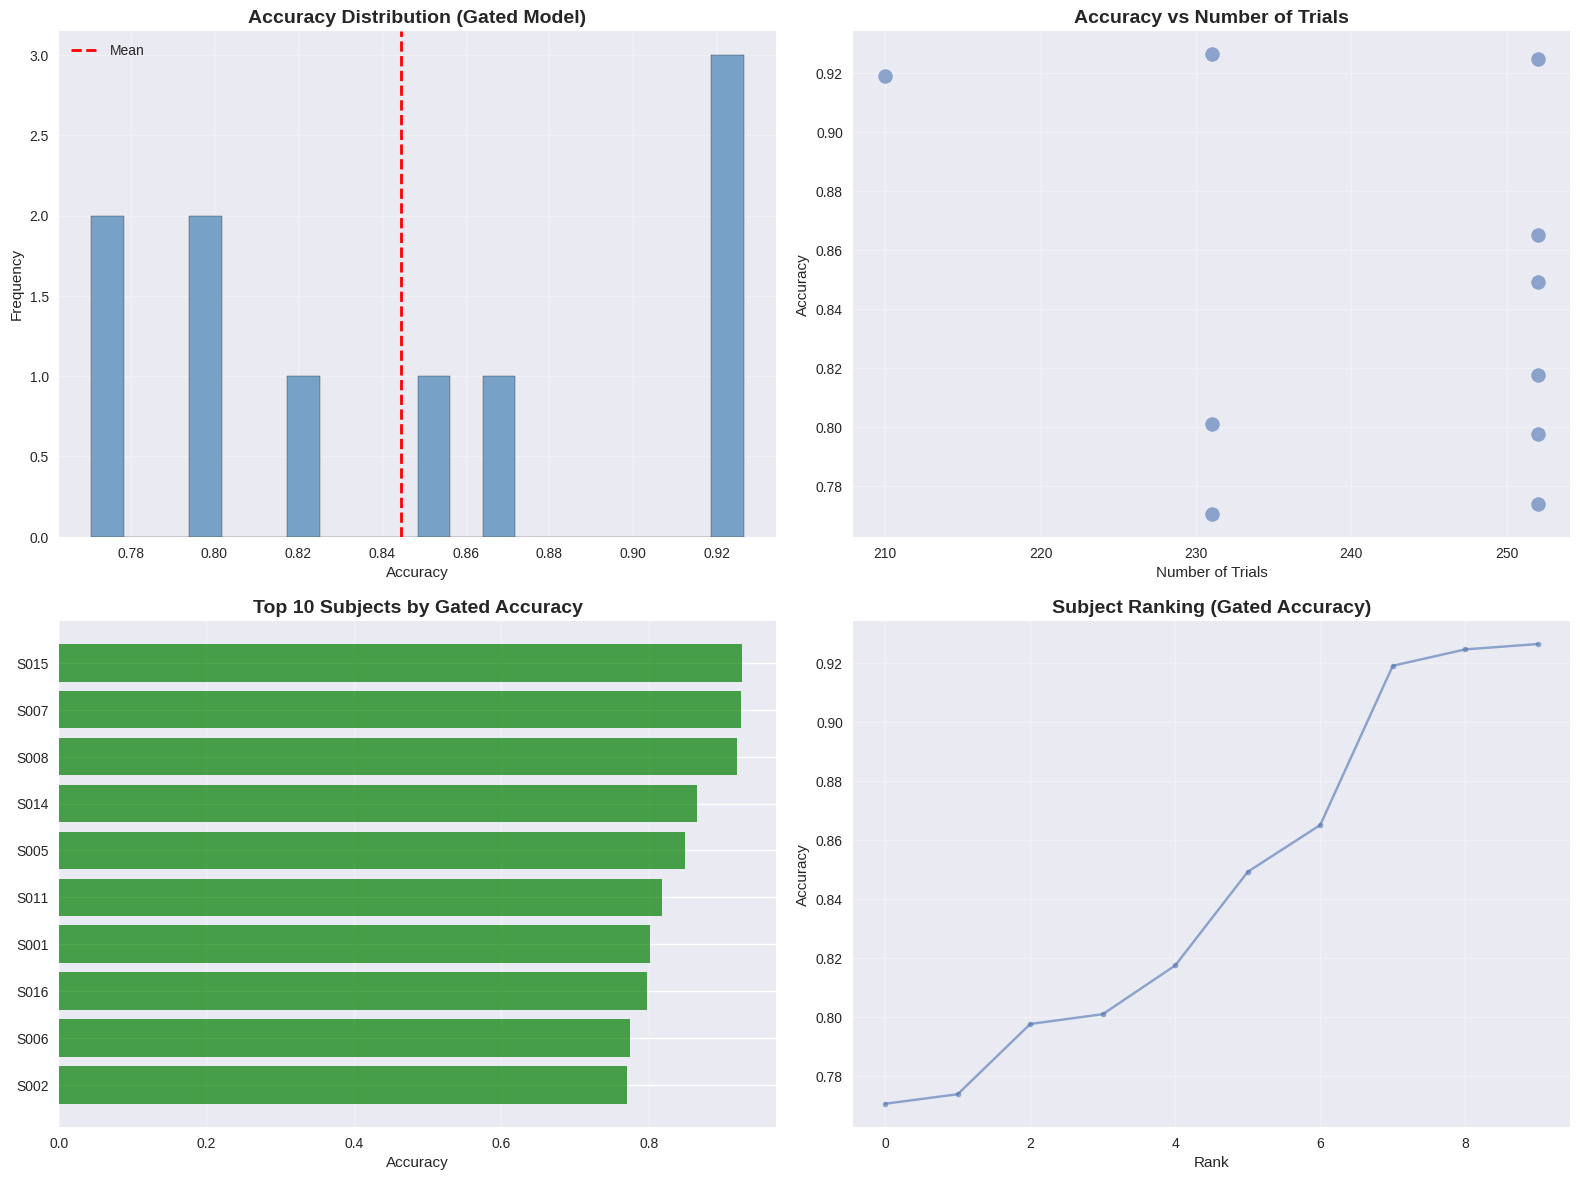

Visualizations saved to: results/trial4_gated_results_summary.png


In [14]:

if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    axes[0, 0].hist(results_df['gated_acc'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(results_df['gated_acc'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 0].set_title('Accuracy Distribution (Gated Model)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(results_df['num_trials'], results_df['gated_acc'], alpha=0.6, s=100)
    axes[0, 1].set_title('Accuracy vs Number of Trials', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Trials')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)

    top_10 = results_df.nlargest(min(10, len(results_df)), 'gated_acc')
    axes[1, 0].barh(range(len(top_10)), top_10['gated_acc'], color='green', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_10)))
    axes[1, 0].set_yticklabels(top_10['subject'])
    axes[1, 0].set_title(f'Top {len(top_10)} Subjects by Gated Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Accuracy')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    sorted_results = results_df.sort_values('gated_acc')
    axes[1, 1].plot(range(len(sorted_results)), sorted_results['gated_acc'], marker='o', markersize=4, alpha=0.6)
    axes[1, 1].set_title('Subject Ranking (Gated Accuracy)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    summary_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['results_summary_figure']
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualizations saved to: {summary_path}")
else:
    print('No results to visualize. Please ensure subjects were successfully trained.')


Visualizing adjacency matrix for best subject: S015
Accuracy: 0.9264


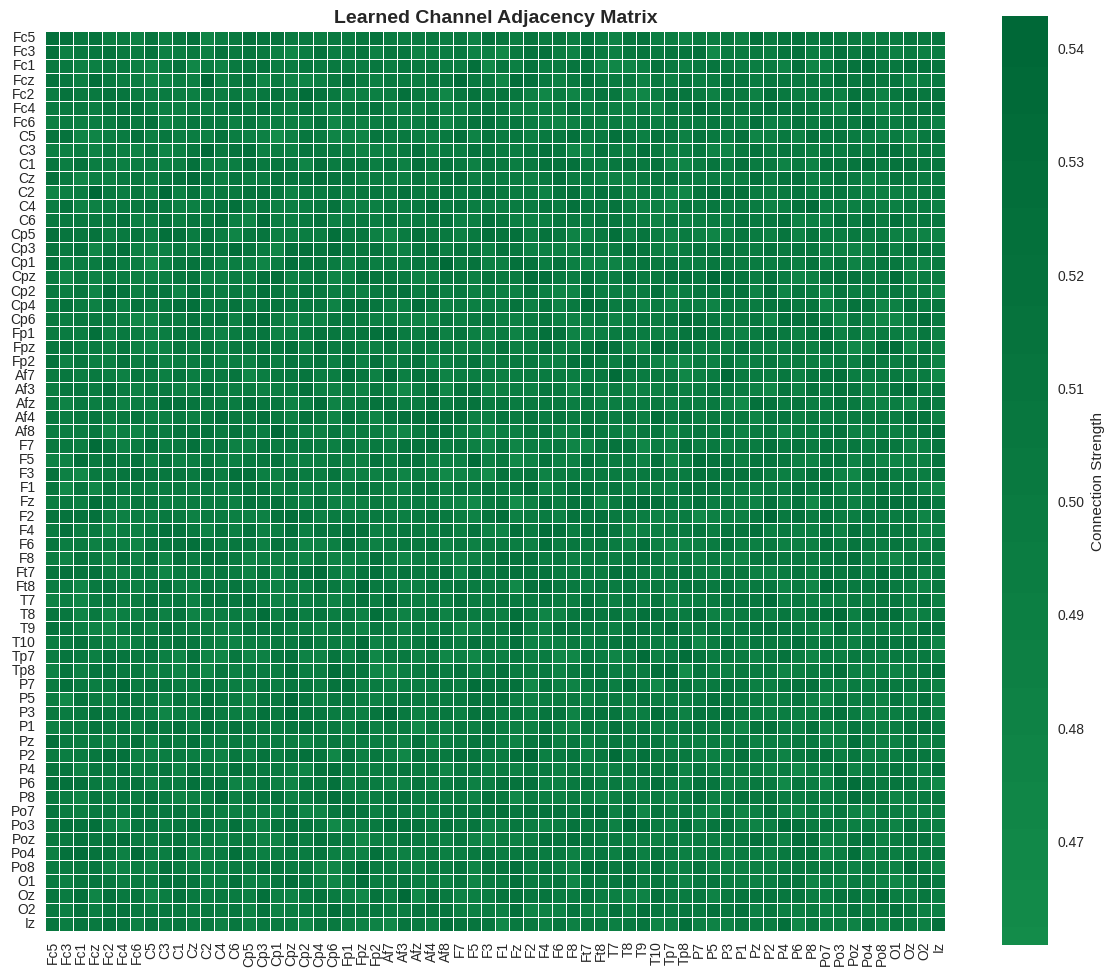

Adjacency figure saved to: results/trial4_adjacency_S015.png
Top 10 Edges (Edge Selection):
Selected channels: ['Fcz', 'C3', 'C2', 'Cp1', 'Cpz', 'Fpz', 'Af7', 'Af3', 'Af8', 'Fz', 'F2', 'Ft8', 'T9', 'Tp7', 'P5', 'P3', 'P2', 'Oz']
Top 10 Channels (Aggregation Selection):
Selected channels: ['Fc5', 'C1', 'Cz', 'C2', 'Cp3', 'Cp4', 'Af4', 'Ft7', 'P3', 'Po3']


In [15]:

if len(all_results) > 0:
    best_idx = results_df['gated_acc'].idxmax()
    best_result = all_results[best_idx]

    print(f"Visualizing adjacency matrix for best subject: {best_result['subject']}")
    print(f"Accuracy: {best_result['gated_acc']:.4f}")

    selector = ChannelSelector(best_result['adjacency_matrix'], best_result['channel_names'])

    adj_path = EXPERIMENT_CONFIG['output']['results_dir'] / f"{EXPERIMENT_CONFIG['output']['adjacency_prefix']}_{best_result['subject']}.png"
    fig = selector.visualize_adjacency(save_path=adj_path)
    plt.show()

    print(f"Adjacency figure saved to: {adj_path}")

    print("Top 10 Edges (Edge Selection):")
    selected_channels_es, _ = selector.edge_selection(10)
    print(f"Selected channels: {selected_channels_es}")

    print("Top 10 Channels (Aggregation Selection):")
    selected_channels_as, _ = selector.aggregation_selection(10)
    print(f"Selected channels: {selected_channels_as}")
else:
    print('No results available for adjacency visualization.')


In [16]:

if len(results_df) > 0:
    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['gated_results_file']
    results_df[['subject', 'num_trials', 'num_channels', 'gated_acc', 'gated_std', 'gate_mean', 'gate_std', 'gate_min', 'gate_max']].to_csv(results_path, index=False)

    if len(channel_selection_df) > 0:
        channel_selection_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['channel_selection_results_file']
        channel_selection_df.to_csv(channel_selection_path, index=False)
    else:
        channel_selection_path = None

    config_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'experiment_config_trial4_gated.json'
    with open(config_path, 'w') as f:
        json.dump(EXPERIMENT_CONFIG, f, indent=2, default=str)

    print('All results exported successfully!')
    print(f'  - Subject results: {results_path}')
    if channel_selection_path:
        print(f'  - Channel selection: {channel_selection_path}')
    print(f'  - Config: {config_path}')
else:
    print('No results to export.')


All results exported successfully!
  - Subject results: results/trial4_gated_subject_results.csv
  - Channel selection: results/trial4_channel_selection_results.csv
  - Config: results/experiment_config_trial4_gated.json
